<a href="https://colab.research.google.com/github/ritazas7/class-work/blob/master/titanic_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Titanic Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

In [0]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving titanic_entropy.csv to titanic_entropy (1).csv
User uploaded file "titanic_entropy.csv" with length 19232 bytes


In [0]:

class DecisionTree:  
  
  """
  The class builds a decision tree model trying to predict the result for specific set of features.
  """
  
  def __init__(self,k,max_depth=100000):
    '''
    The object builder shall receive the the minimum, sample size of the leaf (k) and the optional max_depth

    '''  
    self.k = k
    self.max_depth = max_depth
    
  def entropy_count(self,pair):
    '''
    This method retutns the entropy calculation for two values.
    '''
    if len(pair)==1:
      result = 0
    else:
      pair_sum = pair.sum()
      result =  ((-pair*np.log2(pair/pair_sum)).sum())/pair_sum
    return result
  
  def split_function(self,data_num,target,feature_index,threshold):
    '''
    This method gets as Args:
    1. data_num  it's a feature matrix
    2. target - model's label
    3. feature_index -  the feature's index in data_num
    4. threshold - the  parametrwe use for splitting

    Returns:
    1. child_one - feature matrix that the feature values are less than a treshold
    2. target_one- model's labels hat the feature values are less than a treshold
    3. child_two -feature matrix that the feature values are greater than a treshold
    4. target_two - model's labels hat the feature values are greater than a treshold
    '''
    data_num = np.vstack((target,data_num))
    row,col = data_num.shape
    mask = (data_num[feature_index+1,:] < threshold)
    mask = np.tile(mask,(row,1))
    child_one = data_num[mask].reshape(row,-1)[1:]
    target_one = data_num[mask].reshape(row,-1)[0]
    child_two = data_num[~mask].reshape(row,-1)[1:]
    target_two = data_num[~mask].reshape(row,-1)[0]
    return child_one,child_two,target_one,target_two

  
  def count_lefts(self,feature, y_target, threshold):
    '''
    The method counts samle size of the features lesser than the threshold.
    '''
    return np.unique(y_target[feature < threshold],return_counts=True)[1]
  
  def count_rights(self,feature, y_target, threshold):
    '''
    The method counts samle size of the features greater than the threshold.
    '''
    return np.unique(y_target[feature > threshold],return_counts=True)[1]
  
  def find_thresholds(self,data):
    '''
    The method calculates the threshold of the feature.
    '''
    data= np.unique(data)
    thresholds = (data[1:]+data[:-1])/2
    return thresholds
  
  def _fit_helper(self,X,y,count =1):
    '''
    This method builds the decision tree.
    '''
    cond_entropy_max= 100
    valid_question = False
    for feature_index,feature_data in enumerate(X): #we get index of the feature
      count_pure_one = y.sum()
      count_pure_zero = len(y)-count_pure_one
      thresholds = self.find_thresholds(feature_data)
      feature_length = len(feature_data)
      if count_pure_one!=len(y) and count_pure_zero!=len(y):
        for threshold in thresholds:
          count_left = self.count_lefts(feature_data,y,threshold)
          count_right = self.count_rights(feature_data,y,threshold)
          left_size_group = np.sum(count_left)
          right_size_group = feature_length - left_size_group
          if (left_size_group >= self.k) and (right_size_group >= self.k) and count < self.max_depth:
            entropy_left = self.entropy_count(count_left)
            entropy_right = self.entropy_count(count_right)
            conditional_entropy = (left_size_group*entropy_left+ right_size_group*entropy_right)/feature_length
            if conditional_entropy < cond_entropy_max:
              entropy_l = entropy_left
              entropy_r = entropy_right
              cond_entropy_max = conditional_entropy
              threshold_best = threshold
              feature_index_best = feature_index
              valid_question = True
    if valid_question:
      count += 1
      child_left,child_right,target_left,target_right = self.split_function(X,y,feature_index_best,threshold_best)
      tup1 = self._fit_helper(child_left,target_left,count)
      tup2 = self._fit_helper(child_right,target_right,count)
      result = (feature_index_best,float("%.2f" %threshold_best)), tup1, tup2
    else:
      survived = y.sum()
      dead = feature_length - survived      
      if survived > dead:
        #survived/feature_length
        result = [1,"{0:.0%}".format(survived/feature_length)]
      else:
        result = [0,"{0:.0%}".format(dead/feature_length)]
    return  result
    
  def fit(self,X,y):
    '''
    This method assigns the decision tree result to self.
    '''
    self.tree = self._fit_helper(X,y)
    return self
    
  def _find_leaf(self,tree,x):
    '''
    This method goes down in tree and finds the relevant leaf for x (x is one set of features).
    '''
    if type(tree[0]) is tuple:
      feature_index, threshold = tree[0]
      if threshold > x[feature_index]:
        result = self._find_leaf(tree[1],x)
      else:
        result = self._find_leaf(tree[2],x)
    else:
      result = tree[0]
    return result
    
  def predict(self,X):    
    '''
    This method return the labels for list of features.
    '''
    if  hasattr(self,"tree")==False:
      raise NeedToFit("You need to fit before you predict")
    results = []
    for row in X:
      results.append(self._find_leaf(self.tree,row))
    return results

class NeedToFit(Exception):
  def __init__(self,*args, **kwargs):
    super(NeedToFit,self).__init__(*args, **kwargs)
        
    

In [0]:
with open('titanic_entropy.csv','r') as f:
  lines = f.readlines()
  lines = [line.split(",") for line in lines]
  lines = [[word if index!=6 else word.strip() for index,word in enumerate(line) ] for line in lines]

all_data = map(list,zip(*lines))
all_data = [line for line in all_data]
all_data_num = np.array(all_data)
all_data_num = (all_data_num[:,1:].astype(float))


In [0]:
model = DecisionTree(100)
X,y = all_data_num[1:],all_data_num[0]
model.fit(X,y)
X = all_data_num[1:].T
print(model.predict(X))

[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 

In [0]:
model = DecisionTree(100)
X,y = all_data_num[1:],all_data_num[0]
Z = all_data_num[1:].T
print(model.fit(X,y).predict(Z))


[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 

#Trying to draw

In [0]:
import numpy as np
from IPython.display import Image
import pydotplus
from graphviz import Digraph
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [0]:
def vis_tree(my_tree, tmp_dot=None, node_id=None, parent_id=None):
  need_to_return = False
  if tmp_dot is None:
    tmp_dot = Digraph()
    need_to_return = True
  if node_id is None:
    node_id = [0]
  else:
    node_id[0] += 1
  node_str = str(node_id[0])
  if parent_id is not None:
    tmp_dot.edges([(parent_id, node_str)])
              
  if type(my_tree) is tuple:
    tmp_dot.node(node_str, str(my_tree[0]))

    vis_tree(my_tree[1], tmp_dot, node_id, parent_id=node_str)
    vis_tree(my_tree[2], tmp_dot, node_id, parent_id=node_str)
  
  else:
    tmp_dot.node(node_str, str(my_tree))
    
  return need_to_return and tmp_dot

In [0]:
dot = vis_tree(model.tree)

In [0]:
print(dot);

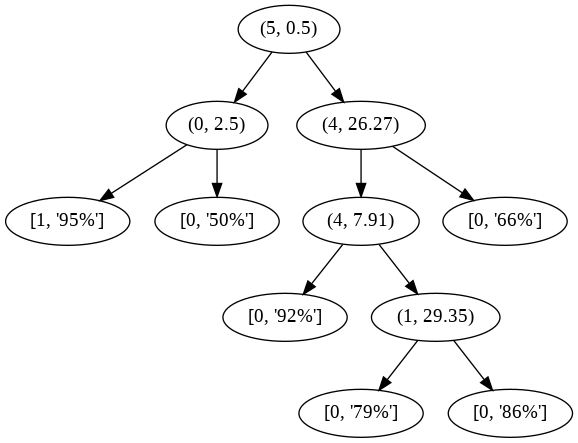

In [0]:
dot.render('test-output/round-table.gv', view=True)  # doctest: +SKIP
'test-output/round-table.gv.pdf'

graph = pydotplus.graph_from_dot_data(str(dot))
Image(graph.create_png())

#Real tree drawing

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
model1 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 100)

In [0]:
X,y = all_data_num[1:].T,all_data_num[0]


In [0]:
model1.fit(X, y).predict(X);

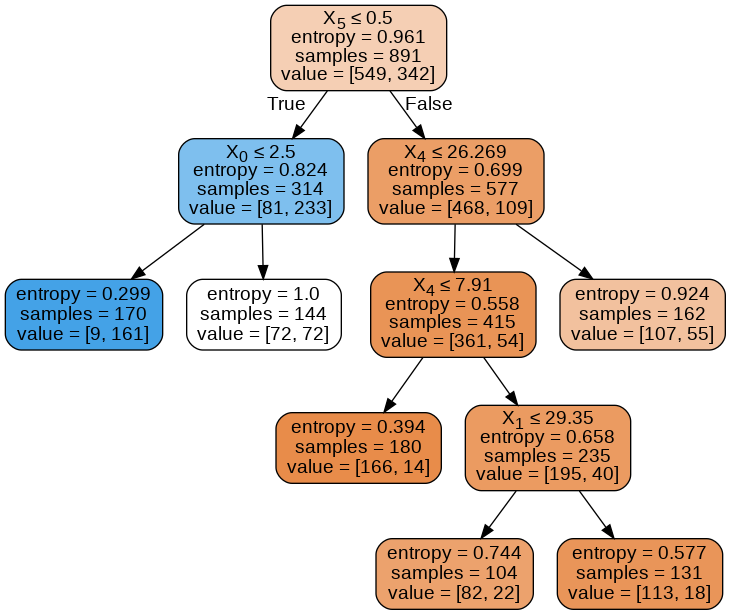

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())